In [1]:
import torch
import torch.nn as nn
import torch.functional as F
from utils import *

class SequenceModel(nn.Module):
    def __init__(self, representationSize, actionSize, recurrentStateSize):
        super().__init__()
        self.representationSize = representationSize
        self.actionSize = actionSize
        self.recurrentStateSize = recurrentStateSize
        self.recurrent = nn.GRUCell(representationSize + actionSize, recurrentStateSize)

    def forward(self, representation, action, recurrentState):
        return self.recurrent(torch.cat((representation, action), -1), recurrentState)
    
    def initializeRecurrentState(self):
        return torch.zeros(self.recurrentStateSize)

class PriorNet(nn.Module):
    def __init__(self, inputSize, representationClasses=16):
        super().__init__()
        self.representationSize = representationClasses
        self.mlp = sequentialModel1D(inputSize, [256, 256], representationClasses**2)
    
    def forward(self, x):
        logits = self.mlp(x)
        stateMatrix = logits.view(-1, self.representationSize, self.representationSize)
        _, indices = torch.max(stateMatrix, dim=-1)
        representation = F.one_hot(indices, num_classes=self.representationSize)
        return representation.view(-1), logits
    
class PosteriorNet(nn.Module):
    def __init__(self, inputSize, representationClasses=16):
        super().__init__()
        self.representationSize = representationClasses
        self.mlp = sequentialModel1D(inputSize, [256, 256], representationClasses**2)
    
    def forward(self, x):
        logits = self.mlp(x)
        stateMatrix = logits.view(-1, self.representationSize, self.representationSize)
        _, indices = torch.max(stateMatrix, dim=-1)
        representation = F.one_hot(indices, num_classes=self.representationSize)
        return representation.view(-1), logits

class ConvEncoder(nn.Module):
    def __init__(self, inputShape, outputSize):
        super(ConvEncoder, self).__init__()
        c, h, w = inputShape
        self.convolutionalNet = nn.Sequential(
            nn.Conv2d(c, 32, kernel_size=4, stride=2, padding=1),  # Output: (32, h/2, w/2)
            nn.Tanh(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # Output: (64, h/4, w/4)
            nn.Tanh(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # Output: (128, h/8, w/8)
            nn.Tanh(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),  # Output: (256, h/16, w/16)
            nn.Tanh(),
            nn.Flatten(),
            nn.Linear(256 * (h // 16) * (w // 16), outputSize),
            nn.Tanh(),
        )

    def forward(self, obs):
        return self.convolutionalNet(obs.float())

class ConvDecoder(nn.Module):
    def __init__(self, inputSize, outputShape):
        super(ConvDecoder, self).__init__()
        self.outputShape = outputShape
        c, h, w = outputShape
        self.fc = nn.Sequential(
            nn.Linear(inputSize, 256 * (h // 16) * (w // 16)),
            nn.Tanh(),
        )
        self.deconvolutionalNet = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # Output: (128, h/8, w/8)
            nn.Tanh(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # Output: (64, h/4, w/4)
            nn.Tanh(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # Output: (32, h/2, w/2)
            nn.Tanh(),
            nn.ConvTranspose2d(32, c, kernel_size=4, stride=2, padding=1),  # Output: (c, h, w)
            nn.Sigmoid(),  # Output pixel values between 0 and 1
        )

    def forward(self, x):
        x = self.fc(x)
        batchSize = x.size(0)
        c, h, w = 256, self.outputShape[1] // 16, self.outputShape[2] // 16
        x = x.view(batchSize, c, h, w)
        return (self.deconvolutionalNet(x))

class RewardPredictor(nn.Module):
    def __init__(self, inputSize):
        super(RewardPredictor, self).__init__()
        self.mlp = sequentialModel1D(inputSize, [256, 256], 1)

    def forward(self, x):
        return self.mlp(x)

In [2]:
import torch
import torch.nn as nn
import torch.functional as F
import torch.optim as optim
from utils import *
import pickle
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

representationClasses = 16
representationSize = representationClasses ** 2
actionSize = 3
recurrentStateSize = 256
compressedObservationsSize = 256
obsShape = (3, 96, 96)
numUpdates = 10

convEncoder     = ConvEncoder(obsShape, compressedObservationsSize).to(device)
convDecoder     = ConvDecoder(representationSize + recurrentStateSize, obsShape).to(device)
sequenceModel   = SequenceModel(representationSize, actionSize, recurrentStateSize).to(device)
priorNet        = PriorNet(recurrentStateSize, representationClasses).to(device)
posteriorNet    = PosteriorNet(recurrentStateSize + compressedObservationsSize, representationClasses).to(device)
rewardPredictor = RewardPredictor(recurrentStateSize + representationSize).to(device)

worldModelOptimizer = optim.AdamW(
    list(convEncoder.parameters()) + 
    list(convDecoder.parameters()) + 
    list(sequenceModel.parameters()) + 
    list(priorNet.parameters()) + 
    list(posteriorNet.parameters()) +
    list(rewardPredictor.parameters()), 
    lr=1e-3
)

In [ ]:
with open('episode_0_data.pkl', 'rb') as f:
    data = pickle.load(f)
observations = data['observations'].to(device).float()/255.0
actions = data['actions'].to(device).float()
rewards = data['rewards'].to(device)
episodeLength = len(actions)

for i in range(1, numUpdates):
    encodedObservations = convEncoder(observations)
    initialRecurrentState = sequenceModel.initializeRecurrentState().to(device)

    posteriorNetOutputs = []
    recurrentStates = [initialRecurrentState]
    priorNetLogits = []
    posteriorNetLogits = []

    for timestep in range(episodeLength):
        posteriorNetOutput, posteriorNetCurrentLogits = posteriorNet(torch.cat((recurrentStates[timestep], encodedObservations[timestep]), -1))
        posteriorNetOutputs.append(posteriorNetOutput)
        posteriorNetLogits.append(posteriorNetCurrentLogits)

        recurrentState = sequenceModel(posteriorNetOutputs[timestep].detach(), actions[timestep], recurrentStates[timestep])
        recurrentStates.append(recurrentState)

        _, priorNetCurrentLogits = priorNet(recurrentStates[timestep])
        priorNetLogits.append(priorNetCurrentLogits)

    posteriorNetOutputs = torch.stack(posteriorNetOutputs)      # [episodeLength    , representationSize]
    recurrentStates = torch.stack(recurrentStates)              # [episodeLength + 1, recurrentStateSize]
    priorNetLogits = torch.stack(priorNetLogits)                # [episodeLength    , representationSize]
    posteriorNetLogits = torch.stack(posteriorNetLogits)        # [episodeLength    , representationSize]
    fullStateRepresentations = torch.cat((recurrentStates[1:], posteriorNetOutputs), -1)

    reconstructedObservations = convDecoder(fullStateRepresentations)
    predictedRewards = rewardPredictor(fullStateRepresentations)

    reconstructionLoss = F.mse_loss(reconstructedObservations, observations[1:], reduction="none").mean(dim=[-1, -2, -3]).mean()
    priorNetLoss = F.mse_loss(priorNetLogits, posteriorNetLogits.detach())
    rewardPredictorLoss = F.mse_loss(predictedRewards, rewards)

    worldModelLoss = reconstructionLoss + priorNetLoss + rewardPredictorLoss

    worldModelOptimizer.zero_grad()
    worldModelLoss.backward()
    worldModelOptimizer.step()

    if i % 100 == 0:
        print(f"Completed {i} training steps")


fullStateRepresentations shape torch.Size([255, 512]) before passing to decoder
fullStateRepresentations shape torch.Size([255, 512]) before passing to decoder
fullStateRepresentations shape torch.Size([255, 512]) before passing to decoder
fullStateRepresentations shape torch.Size([255, 512]) before passing to decoder
fullStateRepresentations shape torch.Size([255, 512]) before passing to decoder
fullStateRepresentations shape torch.Size([255, 512]) before passing to decoder
fullStateRepresentations shape torch.Size([255, 512]) before passing to decoder
fullStateRepresentations shape torch.Size([255, 512]) before passing to decoder
fullStateRepresentations shape torch.Size([255, 512]) before passing to decoder


In [7]:
torch.max(torch.tensor([0.1]), torch.tensor([2.42]))

tensor([2.4200])

In [ ]:
priorDistribution       = torch.distributions.Categorical(logits=priorNetLogits)
posteriorDistribution   = torch.distributions.Categorical(logits=posteriorNetLogits)
priorDistributionSG     = torch.distributions.Categorical(logits=priorNetLogits.detach())
posteriorDistributionSG = torch.distributions.Categorical(logits=posteriorNetLogits.detach())

priorLoss = torch.max(torch.distributions.kl_divergence(posteriorDistributionSG, priorDistribution))
posteriorLoss = torch.max(torch.distributions.kl_divergence(posteriorDistribution, priorDistributionSG))


(torch.Size([255, 256]), torch.Size([255, 256]))

In [4]:
saveImage(np.transpose((observations).cpu()[51]*255, (1, 2, 0)).numpy().astype(np.uint8), "test2.png")

In [5]:
type(np.transpose((observations).cpu()[51], (1, 2, 0)).numpy())

numpy.ndarray

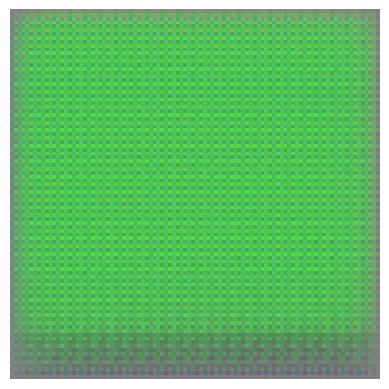

In [6]:
displayImage(np.transpose(reconstructedObservations.detach().cpu().numpy()[50], (1, 2, 0)))

In [5]:
import numpy as np

def lambda_return(rewards, values, gamma=0.99, lam=0.95):
    """
    Calculates the lambda-return for a given sequence of rewards and values.
    
    Parameters:
        rewards (list or np.array): Sequence of rewards from time step 0 to T-1.
        values (list or np.array): Estimated state values from time step 0 to T.
        gamma (float): Discount factor for future rewards, typically between 0 and 1.
        lam (float): Lambda parameter controlling bias-variance trade-off, between 0 and 1.
    
    Returns:
        np.array: Array of lambda returns for each time step.
    """
    T = len(rewards)
    lambda_returns = np.zeros(T)
    G_t = 0

    for t in reversed(range(T)):
        G_t = rewards[t] + gamma * ((1 - lam) * values[t + 1] + lam * G_t)
        lambda_returns[t] = G_t

    return lambda_returns

# Example trajectory
rewards = [1, 0, 0, 1, 0, 2]  # Sample rewards over 6 time steps
values = [0.5, 0.6, 0.4, 0.7, 0.9, 0.8, 0.0]  # State values, with extra for bootstrapping

# Parameters
gamma = 0.99  # Discount factor
lam = 0.95    # Lambda parameter

# Calculate lambda-returns
lambda_returns = lambda_return(rewards, values, gamma, lam)

# Display the results
print("Rewards:", rewards)
print("Values:", values)
print("Lambda-returns:", lambda_returns)


Rewards: [1, 0, 0, 1, 0, 2]
Values: [0.5, 0.6, 0.4, 0.7, 0.9, 0.8, 0.0]
Lambda-returns: [3.45064236 2.57410139 2.71589728 2.8508743  1.9206     2.        ]
